In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from NEExT import NEExT


%reload_ext autoreload
%autoreload 2

In [2]:
edge_file_path = "../data/ABCDO-full/edges.csv"
node_graph_mapping_file_path = "../data/ABCDO-full/graph_mapping.csv"
features_file_path = "../data/ABCDO-full/features.csv"

In [ ]:
from NEExT.io import GraphIO
from NEExT.subgraph_collection import SubGraphCollection
from NEExT.structural_node_features import StructuralNodeFeatures
from NEExT.node_features import NodeFeatures
from NEExT.graph_embeddings import GraphEmbeddings
from NEExT.ml_models import MLModels

target = "is_outlier"
sample_size = 5

graph_io = GraphIO()
subgraph_collection = SubGraphCollection()


graph_collection = graph_io.read_from_csv(
    edges_path=edge_file_path,
    node_graph_mapping_path=node_graph_mapping_file_path,
    node_features_path=features_file_path,
    graph_type="igraph",
)
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=target,
    egonet_algorithm="one-hop",
    skip_features=["community_id"],
)

In [16]:
structural_node_features = StructuralNodeFeatures(
    graph_collection=subgraph_collection,
    feature_list=["all"],
    feature_vector_length=3,
    n_jobs=8,
)
node_features = NodeFeatures(subgraph_collection, feature_list=["random_community_feature"])

structural_features = structural_node_features.compute()
features = node_features.compute()

Computing structural node features:   0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
mode = "structural-embedding"

if mode == "separate-embedding":
    graph_structural_embeddings = GraphEmbeddings(
        graph_collection=subgraph_collection,
        features=structural_features,
        embedding_algorithm="approx_wasserstein",
        embedding_dimension=6,
        random_state=42,
        suffix="struct",
    )
    graph_feature_embeddings = GraphEmbeddings(
        graph_collection=subgraph_collection,
        features=features,
        embedding_algorithm="approx_wasserstein",
        embedding_dimension=1,
        random_state=42,
        suffix="feat",
    )

    structural_embeddings = graph_structural_embeddings.compute()
    feature_embeddings = graph_feature_embeddings.compute()
    embeddings = structural_embeddings + feature_embeddings
elif mode == "combined-embedding":
    combined_features = structural_features + features
    graph_embeddings = GraphEmbeddings(
        graph_collection=subgraph_collection,
        features=combined_features,
        embedding_algorithm="approx_wasserstein",
        embedding_dimension=6,
        random_state=42,
    )
    embeddings = graph_embeddings.compute()
elif mode == "structural-embedding":
    graph_structural_embeddings = GraphEmbeddings(
        graph_collection=subgraph_collection,
        features=structural_features,
        embedding_algorithm="approx_wasserstein",
        embedding_dimension=6,
        random_state=42,
        suffix="struct",
    )
    embeddings = graph_structural_embeddings.compute()


In [21]:
ml_models = MLModels(
    graph_collection=subgraph_collection,
    data_df=embeddings.embeddings_df,
    model_type='classifier',
)

results = ml_models.compute()
print(f"Model trained with average accuracy: {np.mean(results['accuracy']):.4f}")

Model trained with average accuracy: 0.9580


In [24]:
central_node_features = [
    pd.DataFrame(graph.node_attributes).T.reset_index().rename(columns={'index': 'graph_id'}).drop(columns=['community_id', 'is_outlier'])
    for graph in graph_collection.graphs
][0]
central_node_features
# pd.DataFrame(graph_collection.graphs[0].node_attributes).T.reset_index()
# 

,graph_id,random_community_feature
0,72,44.884205
1,84,35.362275
2,93,35.768263
3,94,35.454680
4,101,43.485162
...,...,...
995,754,19.982965
996,832,20.154061
997,909,27.818784
998,927,16.715439


In [25]:
ml_models = MLModels(
    graph_collection=subgraph_collection,
    data_df=central_node_features,
    model_type='classifier',
)

results = ml_models.compute()
print(f"Model trained with average accuracy: {np.mean(results['accuracy']):.4f}")

Model trained with average accuracy: 0.9433


In [ ]:
# add feautres relevant to the ego net, for example distributions of features
from NEExT.subgraph_dataset import combine_structural_with_egonet_features, egonet_features, egonet_node_role_features


egonet_features_df = egonet_features(subgraph_collection)
structural_features = combine_structural_with_egonet_features(structural_features, egonet_features_df)

SubGraphCollection(graphs=[Graph(graph_id=0, graph_label=0, nodes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], edges=[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (2, 5), (0, 6), (1, 6), (2, 6), (0, 7), (6, 7), (0, 8), (2, 8), (6, 8), (0, 9), (4, 9), (0, 10), (1, 10), (2, 10), (0, 11), (2, 11), (5, 11), (7, 11), (0, 12), (2, 12), (6, 12), (7, 12), (8, 12), (10, 12), (0, 13), (2, 13), (7, 13), (8, 13), (10, 13), (0, 14), (5, 14), (0, 15), (0, 16), (6, 16), (0, 17), (2, 17), (12, 17), (13, 17), (0, 18), (2, 18), (6, 18), (8, 18), (10, 18), (0, 19), (11, 19), (17, 19), (0, 20), (2, 20), (14, 20), (0, 21), (8, 21), (10, 21), (0, 22), (2, 22), (5, 22), (16, 22), (18, 22), (0, 23), (2, 23), (6, 23), (0, 24), (7, 24), (10, 24), (12, 24), (16, 24), (0, 25), (6, 25), (7, 25), (20, 25), (0, 26), (0, 27), (0, 28), (2, 28), (10, 28), (12, 28), (13, 28), 

In [3]:
nxt = NEExT()
nxt.set_log_level("INFO")
graph_collection = nxt.read_from_csv(
    edges_path=edge_file_path,
    node_graph_mapping_path=node_graph_mapping_file_path,
    node_features_path=features_file_path,
    # graph_label_path=graph_label_file,
    reindex_nodes=True,
    filter_largest_component=True,
    graph_type="igraph",
    # node_sample_rate=rate
)

2025-03-09 12:33:27,503 - NEExT - INFO - NEExT framework initialized
2025-03-09 12:33:27,505 - NEExT - INFO - Log level set to: INFO
2025-03-09 12:33:27,506 - NEExT - INFO - Reading graph data from CSV files


2025-03-09 12:33:27,598 - NEExT - INFO - Successfully loaded graph collection


In [ ]:
from NEExT.subgraph_collection import SubGraphCollection
from NEExT.subgraph_dataset import create_data_df

target = "community_id"

subgraph_collection = SubGraphCollection()
subgraph_collection.create_egonets_from_graphs(graph_collection, target, "one-hop")

In [ ]:
sample_size = 5

structural_features = nxt.compute_node_features(
    graph_collection=subgraph_collection,
    feature_list=["all"],
    feature_vector_length=3,
    show_progress=True,
    n_jobs=8,
)

2025-03-03 20:03:51,224 - NEExT - INFO - Computing node features: ['all']


Computing node features:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-03-03 20:03:57,680 - NEExT - INFO - Computed features for 17654 nodes


In [ ]:
# add feautres relevant to the ego net, for example distributions of features
from NEExT.subgraph_dataset import combine_structural_with_egonet_features, egonet_features, egonet_node_role_features


egonet_features_df = egonet_features(subgraph_collection)
structural_features = combine_structural_with_egonet_features(structural_features, egonet_features_df)

In [ ]:
# Compute graph embeddings
embeddings = nxt.compute_graph_embeddings(
    graph_collection=subgraph_collection,
    features=structural_features,
    embedding_algorithm="approx_wasserstein",
    embedding_dimension=6,
    random_state=42,
)

# data_df = create_data_df(graph_collection, subgraph_collection, embeddings, target)
# data_df = data_df.rename(columns={'graph_id':'node_id'}).merge(egonet_feature_distribution_features_df).rename(columns={'node_id':'graph_id'})

# Train and evaluate classifier
model_results = nxt.train_ml_model(
    graph_collection=subgraph_collection,
    data_df=embeddings.embeddings_df,
    model_type="classifier",
    sample_size=sample_size,
    balance_dataset=False,
    n_jobs=-1,
)

2025-03-03 20:14:55,257 - NEExT - INFO - Computing graph embeddings using approx_wasserstein


2025-03-03 20:14:55,482 - NEExT - INFO - Computed embeddings for 1000 graphs
2025-03-03 20:14:55,484 - NEExT - INFO - Training classifier model on graph embeddings
2025-03-03 20:14:56,820 - NEExT - INFO - Model trained with average accuracy: 0.2993


In [36]:
# egonet_feature_distribution_features_df
data_df


,graph_id,emb_0,emb_1,emb_2,emb_3,random_community_feature
0,0,1.609062,0.313835,-0.399222,-0.044831,44.884205
1,1,2.089352,0.833148,-0.228314,0.038283,35.362275
2,2,0.446693,1.145038,-0.198976,-0.250623,35.768263
3,3,0.764788,1.218657,-0.208388,0.086298,35.454680
4,4,0.517155,1.219039,-0.199112,-0.158297,43.485162
...,...,...,...,...,...,...
995,995,1.528229,-0.844885,-0.690632,-0.239734,2.463677
996,996,0.565709,-0.428195,-0.558909,0.152021,-23.901251
997,997,0.977535,-0.288195,-0.578132,-0.084924,-26.308426
998,998,0.909945,-0.368227,-0.583273,0.164225,-55.630206


In [ ]:
# 0.5433


,graph_id,emb_0,emb_1,emb_2,emb_3,random_community_feature,random_community_feature_mean,random_community_feature_std,random_community_feature_q_5,random_community_feature_q_95
0,0,1.772884,-0.872195,-0.243377,-0.070068,44.884205,7.111104,35.083553,-43.105376,53.532408
1,1,2.229636,-0.666823,-0.214899,-0.108337,35.362275,19.135156,30.279719,-41.142889,52.160127
2,2,0.670677,-1.437312,0.131600,0.008907,35.768263,24.536752,29.828532,-34.126616,53.222473
3,3,0.972037,-1.292639,0.076199,0.075720,35.454680,26.355652,24.899968,-22.273082,55.258132
4,4,0.737253,-1.405952,0.105216,0.020540,43.485162,26.186332,29.627515,-28.657030,50.884630
...,...,...,...,...,...,...,...,...,...,...
995,995,1.703328,-0.926018,-0.281561,-0.255663,2.463677,-18.643682,29.276369,-54.771136,26.347594
996,996,0.789871,-1.389796,0.303309,-0.118646,-23.901251,-10.170853,25.701107,-33.535719,37.932280
997,997,1.173507,-1.153192,-0.203074,0.090608,-26.308426,-6.845424,28.271255,-42.060824,41.061634
998,998,1.110070,-1.191294,-0.111039,0.279385,-55.630206,-8.649404,31.358503,-56.377541,35.976463


# Community attempt

In [ ]:
graph_collection_inner = GraphCollection(graph_type="igraph")
graph_collection_inner.graph_id_node_array = []

for graph in graph_collection.graphs:
    # DEFINE SOME WAY TO SPLIT THE GRAPH
    community_detection = graph.G.community_leiden(objective_function="modularity", n_iterations=10, resolution=5)
    subgraphs = community_detection.subgraphs()
    node_community_mapping = {k: v for k, v in enumerate(community_detection.membership)}

    for graph_id, subgraph in enumerate(subgraphs):
        nodes = list(range(graph.vcount()))
        edges = subgraph.get_edgelist()
        subgraph_label = None
        # node_attributes = graph.get("node_attributes", {})
        # edge_attributes = graph.get("edge_attributes", {})
        node_attributes = {}
        edge_attributes = {}

        subgraph = Graph(
            graph_id=graph_id,
            graph_label=subgraph_label,
            nodes=nodes,
            edges=edges,
            node_attributes=node_attributes,
            edge_attributes=edge_attributes,
            graph_type=graph_collection_inner.graph_type,
        )
        subgraph.initialize_graph()
        graph_collection_inner.graphs.append(subgraph)
        # Update graph_id_node_array with this graph's nodes
        graph_collection_inner.graph_id_node_array.extend([graph_id] * len(subgraph.nodes))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sample_size = 5


structural_features = nxt.compute_node_features(
    graph_collection=graph_collection_inner,
    feature_list=["all"],
    feature_vector_length=3,
    show_progress=False,
)

# Get number of features
num_features = len([col for col in structural_features.features_df.columns if col not in ["node_id", "graph_id"]])

# Compute graph embeddings
embeddings = nxt.compute_graph_embeddings(
    graph_collection=graph_collection_inner,
    features=structural_features,
    embedding_algorithm="approx_wasserstein",
    embedding_dimension=4,
    random_state=42,
)


x = embeddings.embeddings_df.copy().drop(columns=["graph_id"])
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        # ("mds", MDS(n_components=2)),
        ("cluster", KMeans(n_clusters=3)),
    ]
).fit(x)

cluster_assignment = list(pipe.predict(x))
x["cluster"] = cluster_assignment
# clusters
for graph in graph_collection_inner.graphs:
    graph.set_graph_label(cluster_assignment[graph.graph_id])
# # Train and evaluate classifier
model_results = nxt.train_ml_model(
    graph_collection=graph_collection_inner,
    embeddings=embeddings,
    model_type="classifier",
    sample_size=sample_size,
    balance_dataset=False,
    n_jobs=-1,
)

2025-03-01 17:08:40,606 - NEExT - INFO - Computing node features: ['all']


2025-03-01 17:08:42,183 - NEExT - INFO - Computed features for 1000 nodes
2025-03-01 17:08:42,185 - NEExT - INFO - Computing graph embeddings using approx_wasserstein
2025-03-01 17:08:47,165 - NEExT - INFO - Computed embeddings for 88 graphs
2025-03-01 17:08:47,184 - NEExT - INFO - Training classifier model on graph embeddings
2025-03-01 17:08:48,532 - NEExT - INFO - Model trained with average accuracy: 0.8741


<Axes: xlabel='emb_0', ylabel='emb_1'>

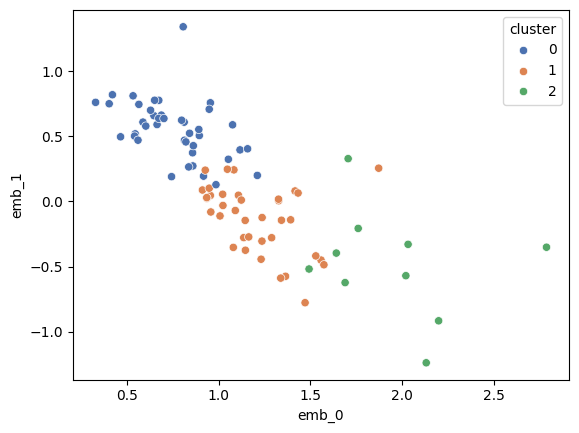

In [ ]:
# graph_collection_inner.graphs
import seaborn as sns

sns.scatterplot(data=x, x="emb_0", y="emb_1", hue="cluster", palette="deep")

In [ ]:
# node_community_mapping

X_df = structural_features.features_df.copy().reset_index().rename(columns={"index": "og_node_id"})  # .drop(columns=['node_id', 'graph_id'])
X_df["subgraph_id"] = x["og_node_id"].map(node_community_mapping)
X_df = X_df.merge(
    embeddings.embeddings_df.rename(columns={"graph_id": "subgraph_id"}),
    on="subgraph_id",
).drop(columns=["og_node_id", "subgraph_id"])

y = X_df[embeddings.embedding_columns]
X = X_df[structural_features.feature_columns]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4578
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 24
[LightGBM] [Info] Start training from score 1.224149


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

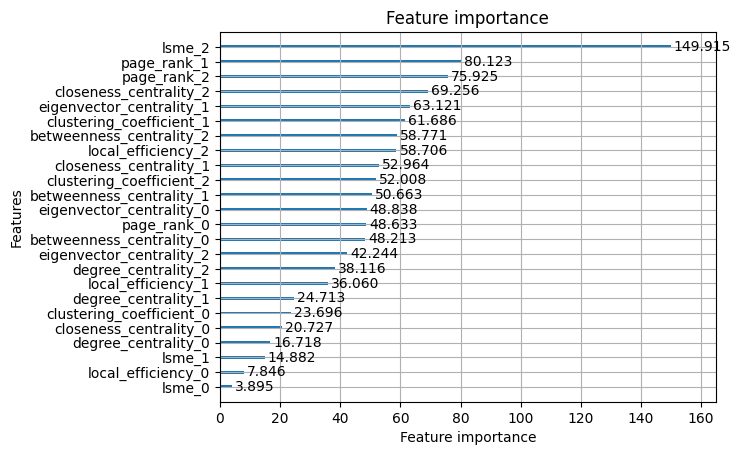

In [ ]:
import lightgbm as lgb


# features.features_df

model = lgb.LGBMRegressor(importance_type="gain")
model.fit(X, y["emb_0"])
# model.feature_importances_
lgb.plot_importance(model)